#Data acqusition and data pre-processing

     |████████████████████████████████| 286kB 11.4MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 1.5MB 12.7MB/s 
     |████████████████████████████████| 2.6MB 31.7MB/s 
     |████████████████████████████████| 184kB 41.8MB/s 
     |████████████████████████████████| 3.1MB 42.6MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 245kB 51.2MB/s 


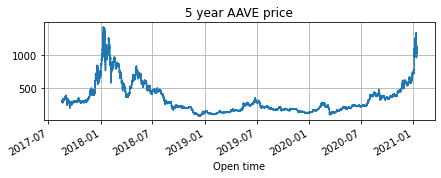

In [ ]:
!pip install python-binance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
import tensorflow as tf
keras = tf.keras

apiKey = "***"
secretKey = "***"
 
client = Client(apiKey, secretKey)
 
symbol = "ETHUSDT"
 
currency = client.get_historical_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_1HOUR, start_str="10 year ago UTC")
 
currency = pd.DataFrame(currency, columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume',
                                  'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
 
currency['Open time'] = pd.to_datetime(currency['Open time'], unit='ms')
 
currency.set_index('Open time', inplace = True)
currency['Close'] = currency['Close'].astype(float)
currency['Volume'] = currency['Volume'].astype(float)
currency['Open'] = currency['Open'].astype(float)
currency['High'] = currency['High'].astype(float)
currency['Low'] = currency['Low'].astype(float)
currency = currency.drop(currency[['Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']], 1)
 
currency['Close'].plot(figsize=(7,2), title = '5 year AAVE price', grid=True)
 
data = currency.filter(['Close'])
data = data[:-1]
dataset = data.values
series = dataset[:,0]

In [ ]:
#Train and validation dataset preparation
x_train = series[:int(len(series)*0.8)]
x_val = series[int(len(series)*0.8):]
print("Test dataset size:       ", x_train.shape[0])
print("Validation dataset size: ", x_val.shape[0])

#Helpful functions definitions:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Test dataset size:        23806
Validation dataset size:  5952


#Model training I - define learning rate

In [ ]:
#Model training I
import tensorflow as tf
keras = tf.keras

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
186/186 [==============================] - 11s 19ms/step - loss: 402.0658 - mae: 402.5658
Epoch 2/100
186/186 [==============================] - 4s 19ms/step - loss: 94.2802 - mae: 94.7688
Epoch 3/100
186/186 [==============================] - 4s 19ms/step - loss: 19.8602 - mae: 20.3302
Epoch 4/100
186/186 [==============================] - 4s 20ms/step - loss: 9.7223 - mae: 10.1823
Epoch 5/100
186/186 [==============================] - 4s 19ms/step - loss: 5.3860 - mae: 5.8348
Epoch 6/100
186/186 [==============================] - 4s 20ms/step - loss: 4.1824 - mae: 4.6232
Epoch 7/100
186/186 [==============================] - 4s 19ms/step - loss: 3.9764 - mae: 4.4133
Epoch 8/100
186/186 [==============================] - 4s 19ms/step - loss: 3.9851 - mae: 4.4210
Epoch 9/100
186/186 [==============================] - 4s 19ms/step - loss: 3.9443 - mae: 4.3777
Epoch 10/100
186/186 [==============================] - 4s 19ms/step - loss: 3.9713 - mae: 4.4061
Epoch 11/100
186/18

(0.0001, 0.1, 0.0, 30.0)

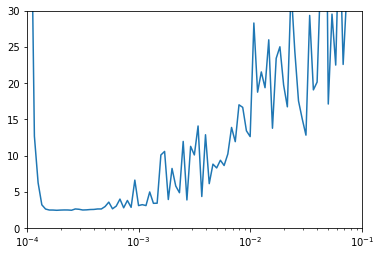

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

#Model training II - using best learning rate from previous step to avoid overfitting

In [ ]:
#Model training II
#Define learning rate from previous step here:
#####
lr = 3e-3
#####

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_val, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=lr)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
186/186 [==============================] - 6s 25ms/step - loss: 73.3359 - mae: 73.8173 - val_loss: 4.6646 - val_mae: 5.1214
Epoch 2/500
186/186 [==============================] - 4s 23ms/step - loss: 13.3191 - mae: 13.7892 - val_loss: 4.0277 - val_mae: 4.4746
Epoch 3/500
186/186 [==============================] - 4s 23ms/step - loss: 10.4883 - mae: 10.9560 - val_loss: 3.4300 - val_mae: 3.8710
Epoch 4/500
186/186 [==============================] - 4s 23ms/step - loss: 9.9014 - mae: 10.3665 - val_loss: 3.1011 - val_mae: 3.5341
Epoch 5/500
186/186 [==============================] - 4s 23ms/step - loss: 13.7977 - mae: 14.2659 - val_loss: 3.1209 - val_mae: 3.5542
Epoch 6/500
186/186 [==============================] - 4s 23ms/step - loss: 6.9045 - mae: 7.3685 - val_loss: 2.7628 - val_mae: 3.1892
Epoch 7/500
186/186 [==============================] - 4s 23ms/step - loss: 6.4476 - mae: 6.8990 - val_loss: 2.5104 - val_mae: 2.9303
Epoch 8/500
186/186 [==============================] 

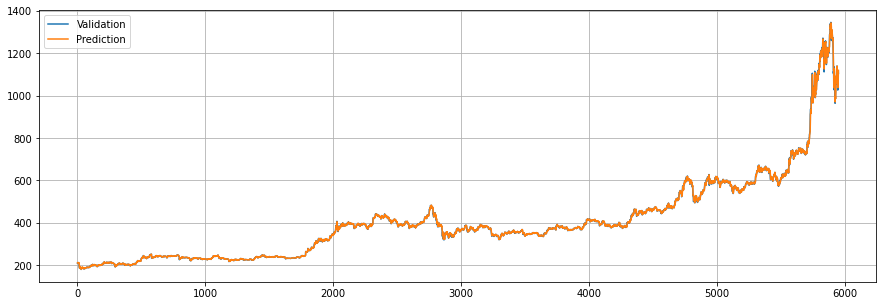

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")
window_size = 64
forecast = model_forecast(model, series[:,  np.newaxis], window_size)
forecast = forecast[int(len(series)*0.8) - window_size:-1, -1, 0]

plt.figure(figsize=(15,5))
plt.plot(x_val, label="Validation")
plt.plot(forecast, label="Prediction")
plt.legend()
plt.grid()

#Model training III - model trained on full set of data

In [ ]:
#Model training III

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(series, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=lr)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=200)

Epoch 1/200
232/232 [==============================] - 5s 19ms/step - loss: 68.1208 - mae: 68.5976
Epoch 2/200
232/232 [==============================] - 4s 18ms/step - loss: 13.4438 - mae: 13.9098
Epoch 3/200
232/232 [==============================] - 4s 19ms/step - loss: 15.0923 - mae: 15.5549
Epoch 4/200
232/232 [==============================] - 4s 19ms/step - loss: 11.4963 - mae: 11.9683
Epoch 5/200
232/232 [==============================] - 4s 19ms/step - loss: 13.7781 - mae: 14.2392
Epoch 6/200
232/232 [==============================] - 4s 19ms/step - loss: 10.5781 - mae: 11.0452
Epoch 7/200
232/232 [==============================] - 4s 18ms/step - loss: 14.9864 - mae: 15.4567
Epoch 8/200
232/232 [==============================] - 4s 19ms/step - loss: 7.2094 - mae: 7.6822
Epoch 9/200
232/232 [==============================] - 4s 18ms/step - loss: 8.8840 - mae: 9.3372
Epoch 10/200
232/232 [==============================] - 4s 19ms/step - loss: 11.4977 - mae: 11.9594
Epoch 11/200


#Check the model results vs. validation data and save the model.

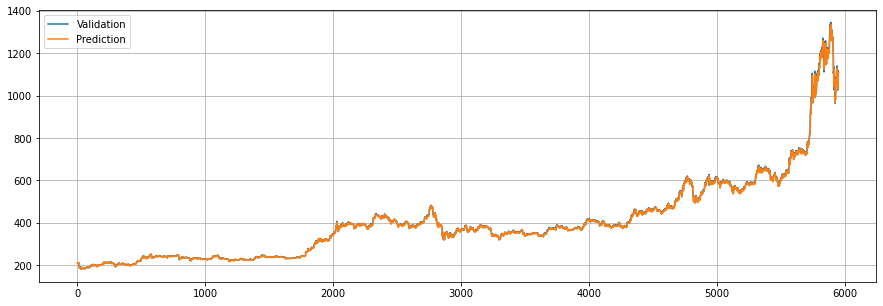

In [ ]:
#model = keras.models.load_model("my_checkpoint.h5")
window_size = 64
forecast = model_forecast(model, series[:,  np.newaxis], window_size)
forecast = forecast[int(len(series)*0.8) - window_size:-1, -1, 0]

plt.figure(figsize=(15,5))
plt.plot(x_val, label="Validation")
plt.plot(forecast, label="Prediction")
plt.legend()
plt.grid()

keras.models.save_model(model, "ETHUSDT-1H-model.h5")

In [ ]:
keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ETHUSDT-1H-model.h5")